# Heat equation - Retrieving operator through ODE solving

In [1039]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [990]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

d = 0.005;
k = 1.;
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

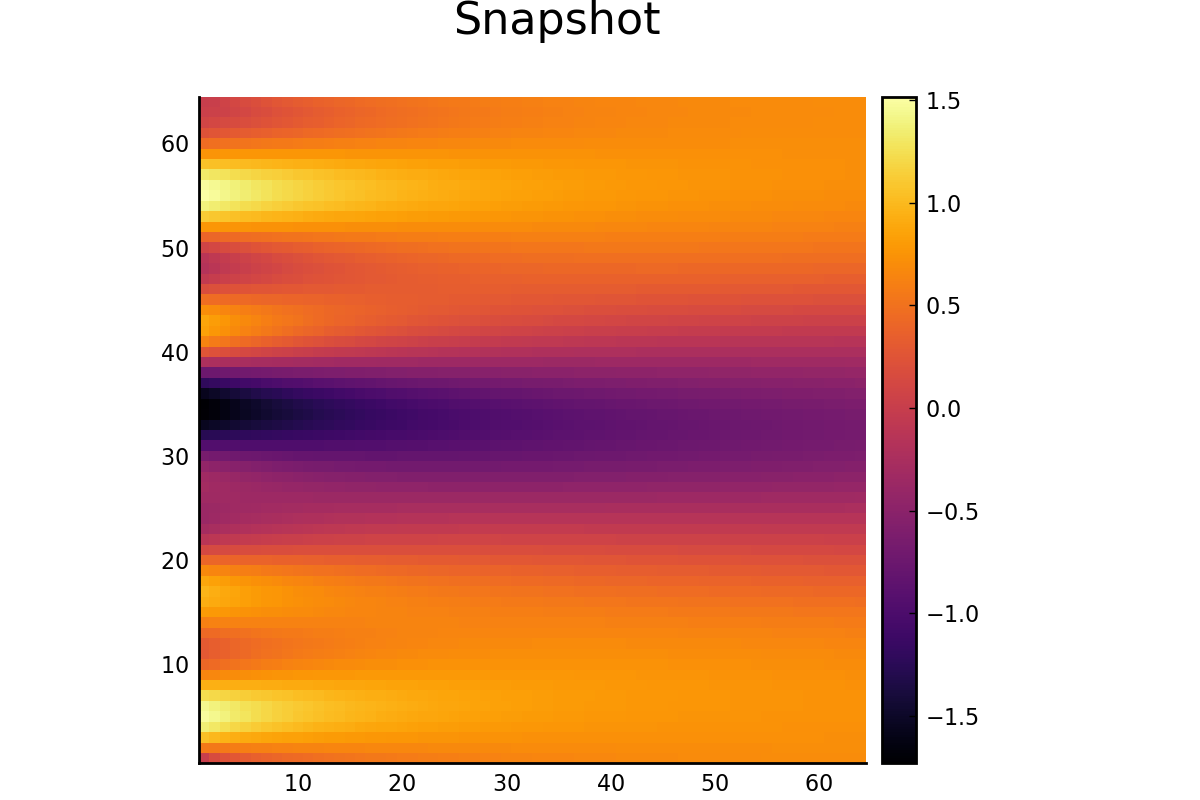

In [899]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c, k);
t, u = Equations.get_heat_fft(t, dx, x_n, d, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

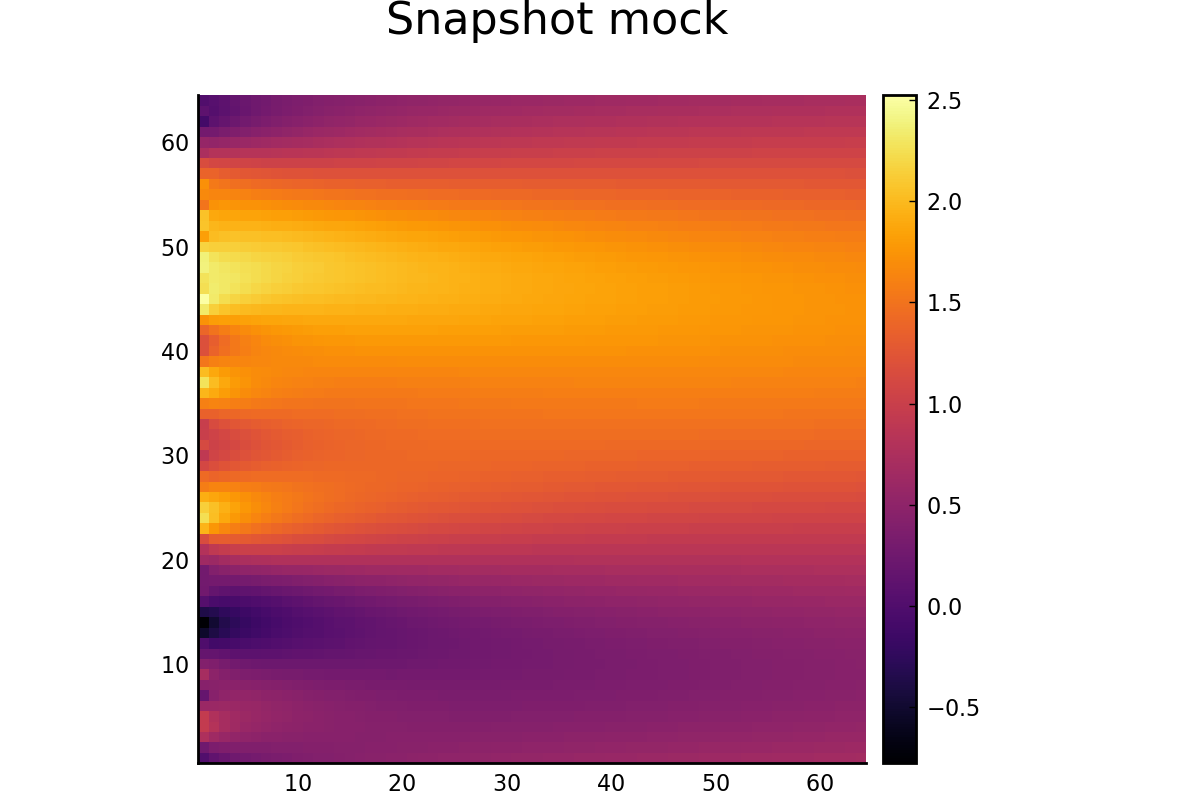

In [914]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 3, 0.01, 0.0001);
GraphicTools.show_state(u_a, "Snapshot mock")

## Generate dataset

In [ ]:
function syver_cond(t_max, t_min, x_max, x_min, t_n, x_n)
    function create_solution(c, k)
        u(x, t) = sum(c * exp(-κ * (π * k / L)^2 * t) * X(k, x) for (c, k) in zip(c, k))
        ∂u∂t(x, t) =
            -sum(
                c * κ * (π * k / L)^2 * exp(-κ * (π * k / L)^2 * t) * X(k, x) for
                (c, k) ∈ zip(c, k)
            )
        u, ∂u∂t
    end
    
    tsnap = LinRange(t_min, t_max, t_n)#[2:end]
    nsample = 200
    K = 50
    k = 1:K
    c = [randn(K) ./ k for _ = 1:nsample]
    solutions = [create_solution(c, k) for c ∈ c]
    u = [s[1] for s ∈ solutions]
    ∂u∂t = [s[2] for s ∈ solutions]
    init = [u(x, 0.0) for x ∈ x, u ∈ u]
    train = [u(x, t) for x ∈ x, u ∈ u, t ∈ tsnap]
    ∂train∂t = [∂u∂t(x, t) for x ∈ x, ∂u∂t ∈ ∂u∂t, t ∈ tsnap]
    return tsnap, init, train
end

syver_dataset = syver_cond(t_max, t_min, x_max, x_min, t_n, x_n);

In [948]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 32, 2, 0.005, 1., "high_dim_training_set.jld2", "training_set");
dataset = Generator.read_dataset("./src/dataset/high_dim_training_set.jld2")["training_set"];

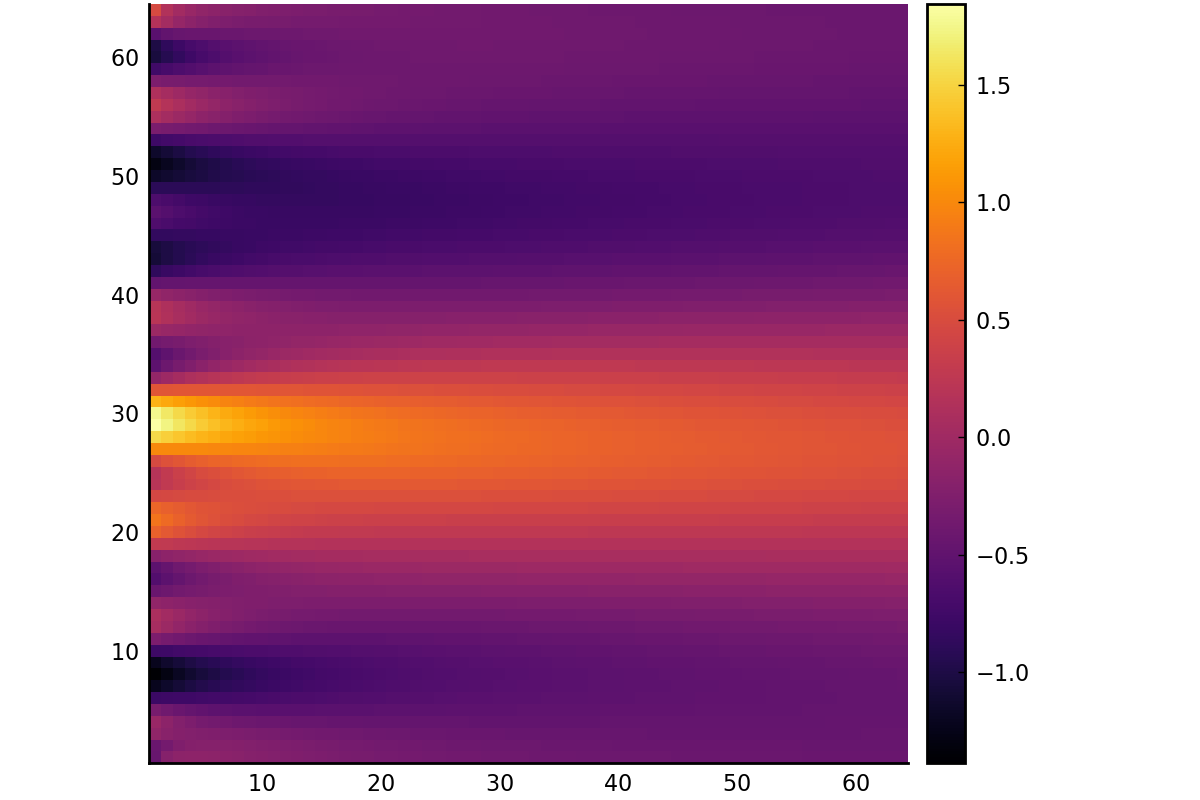

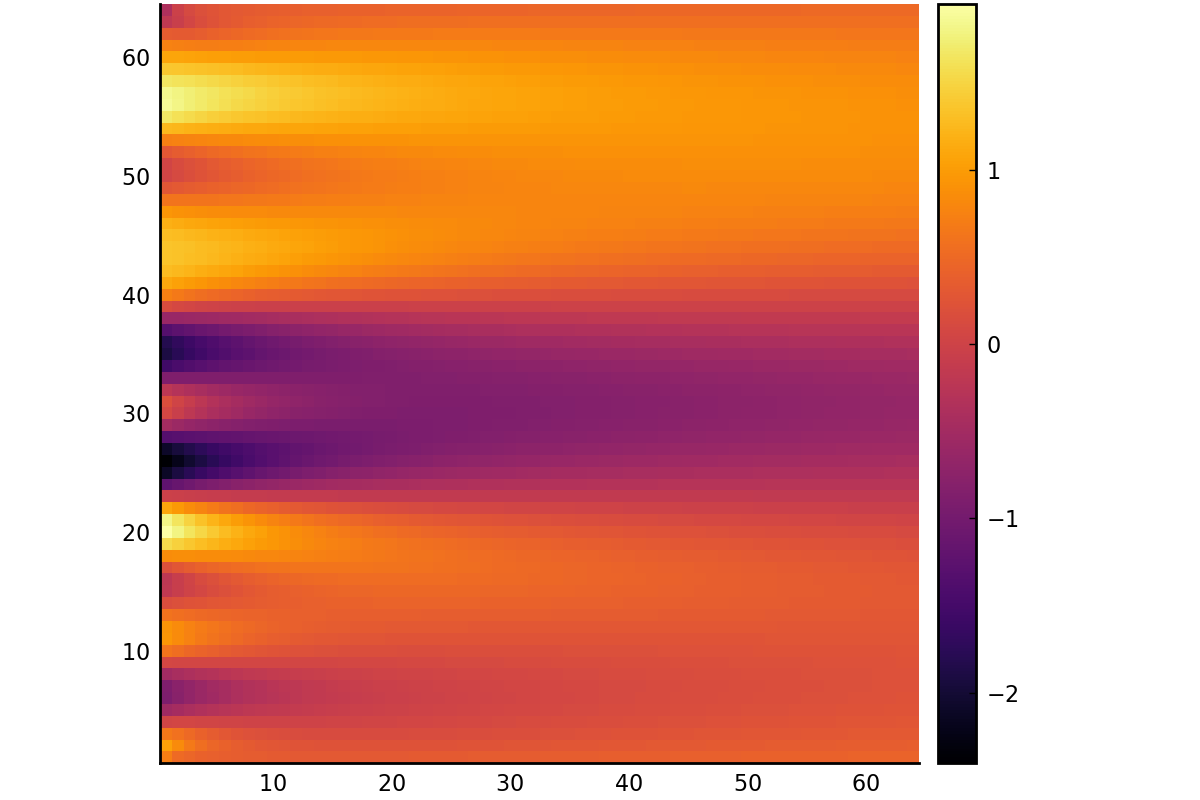

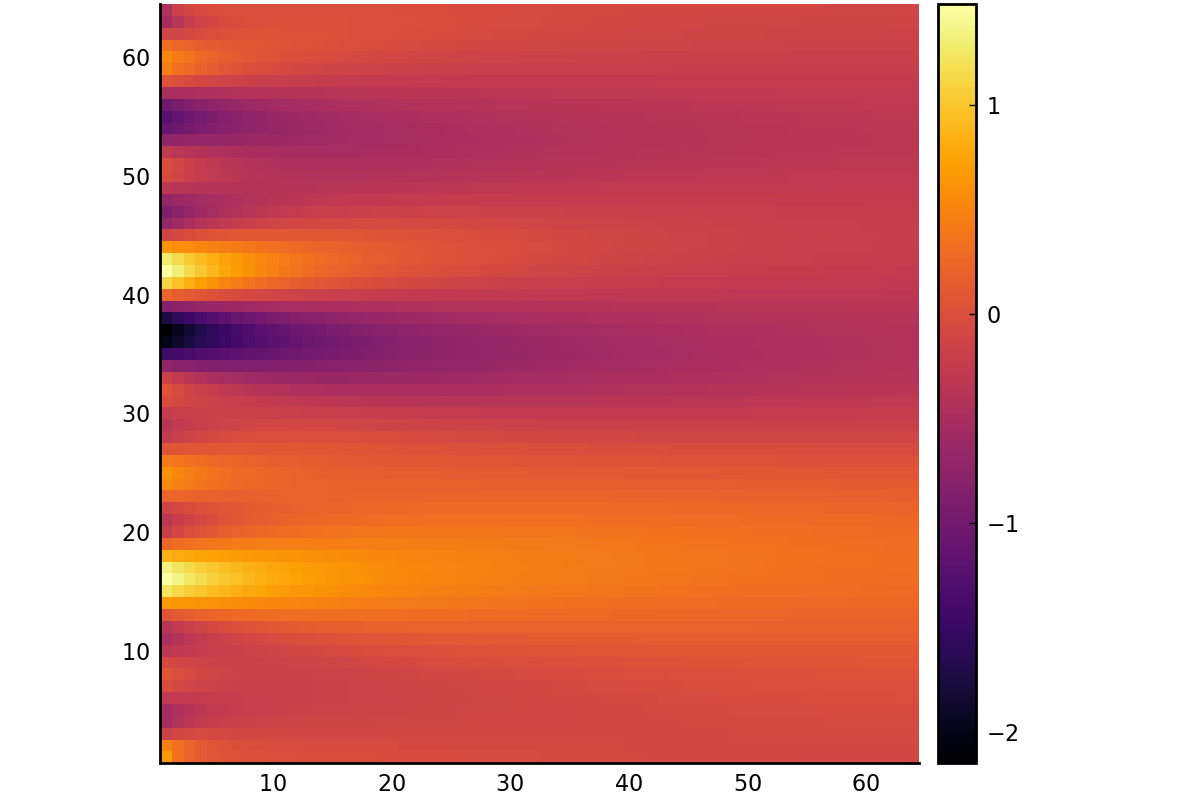

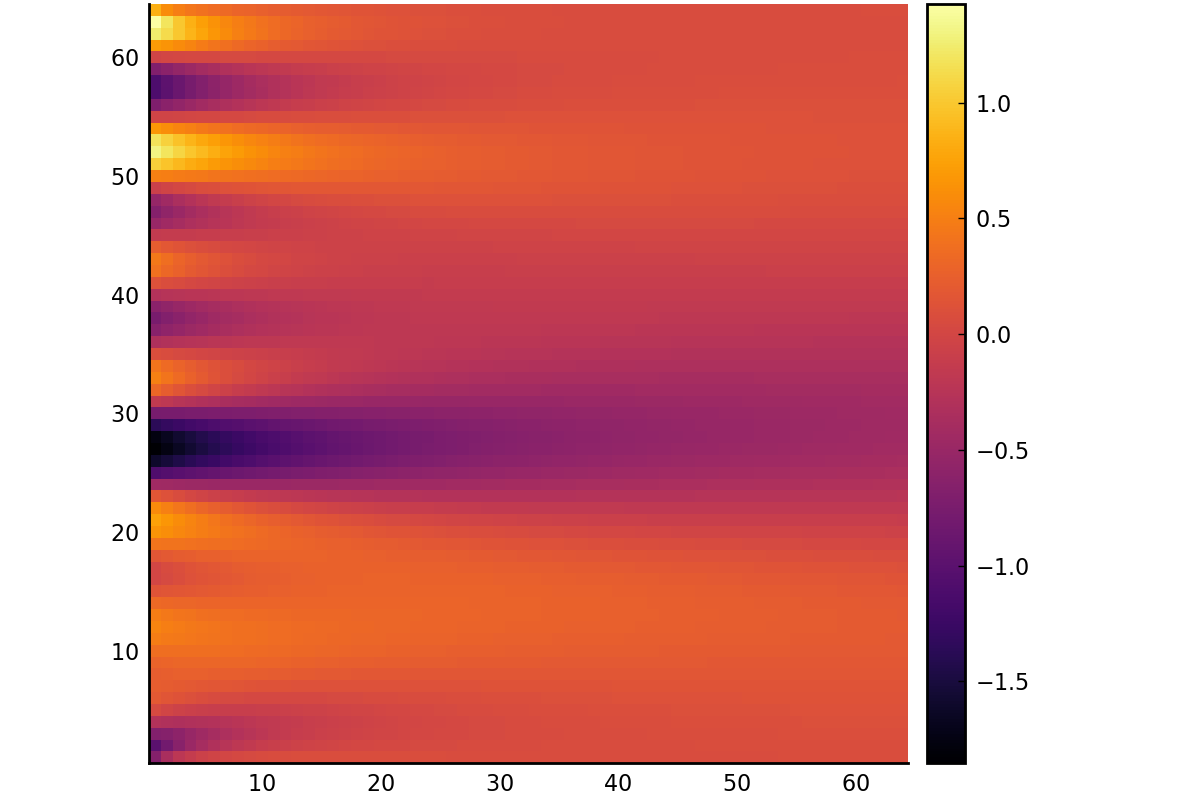

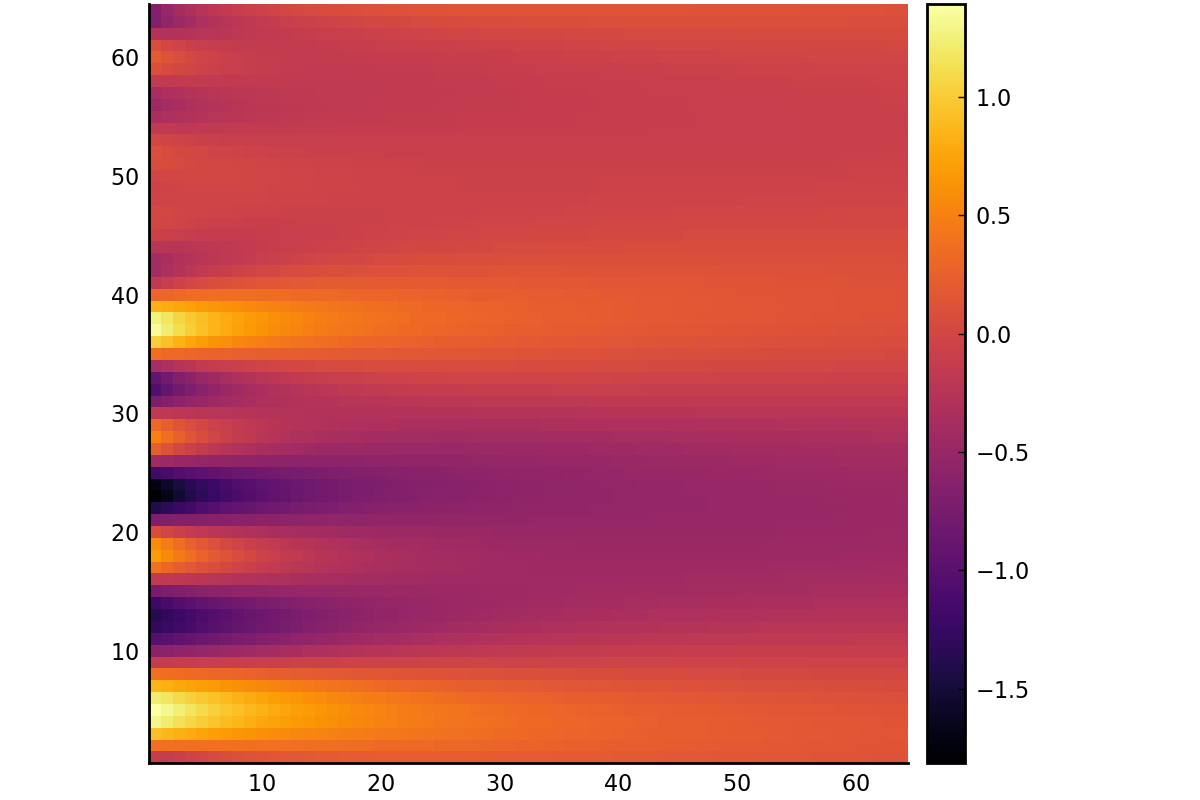

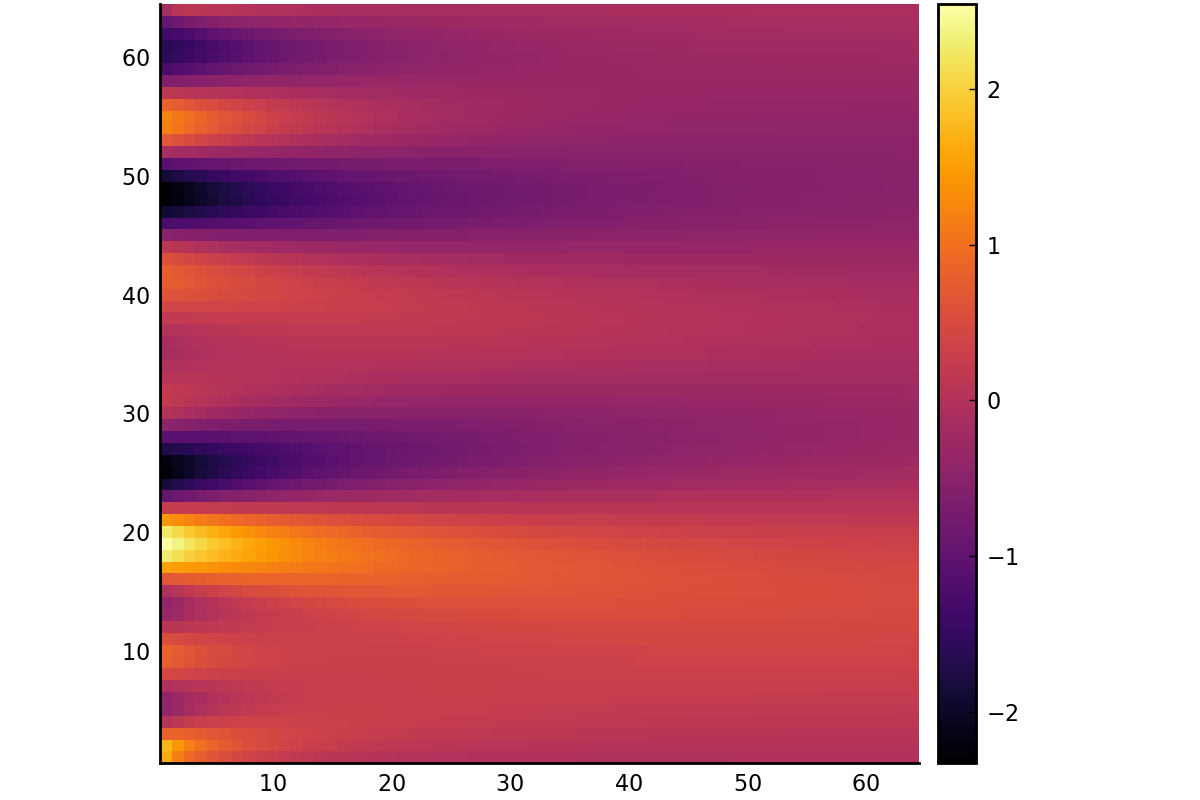

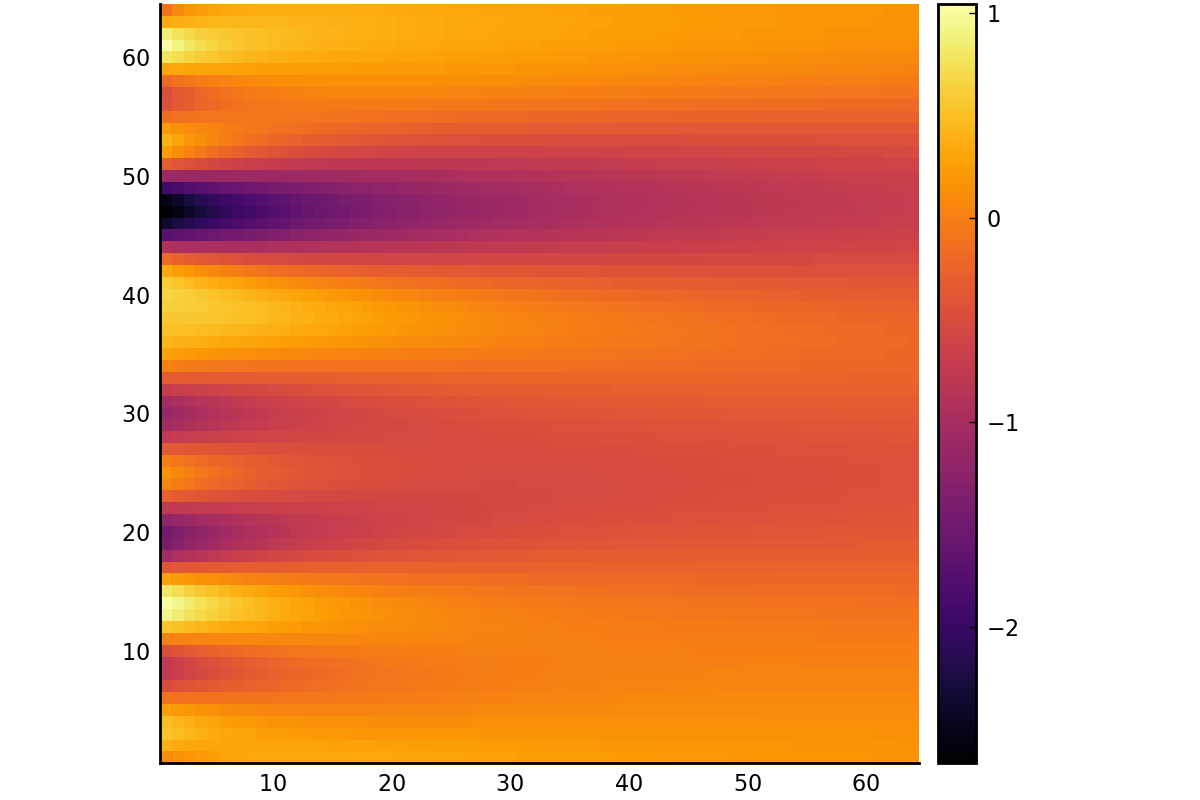

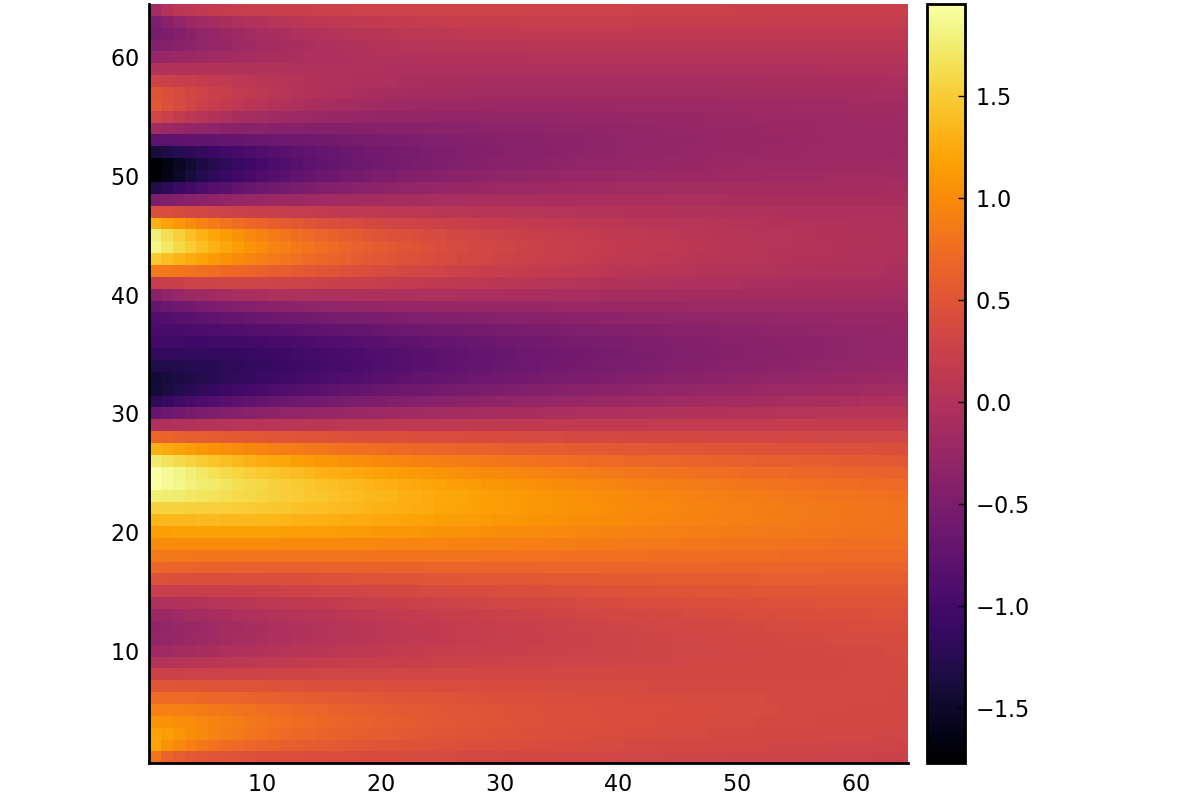

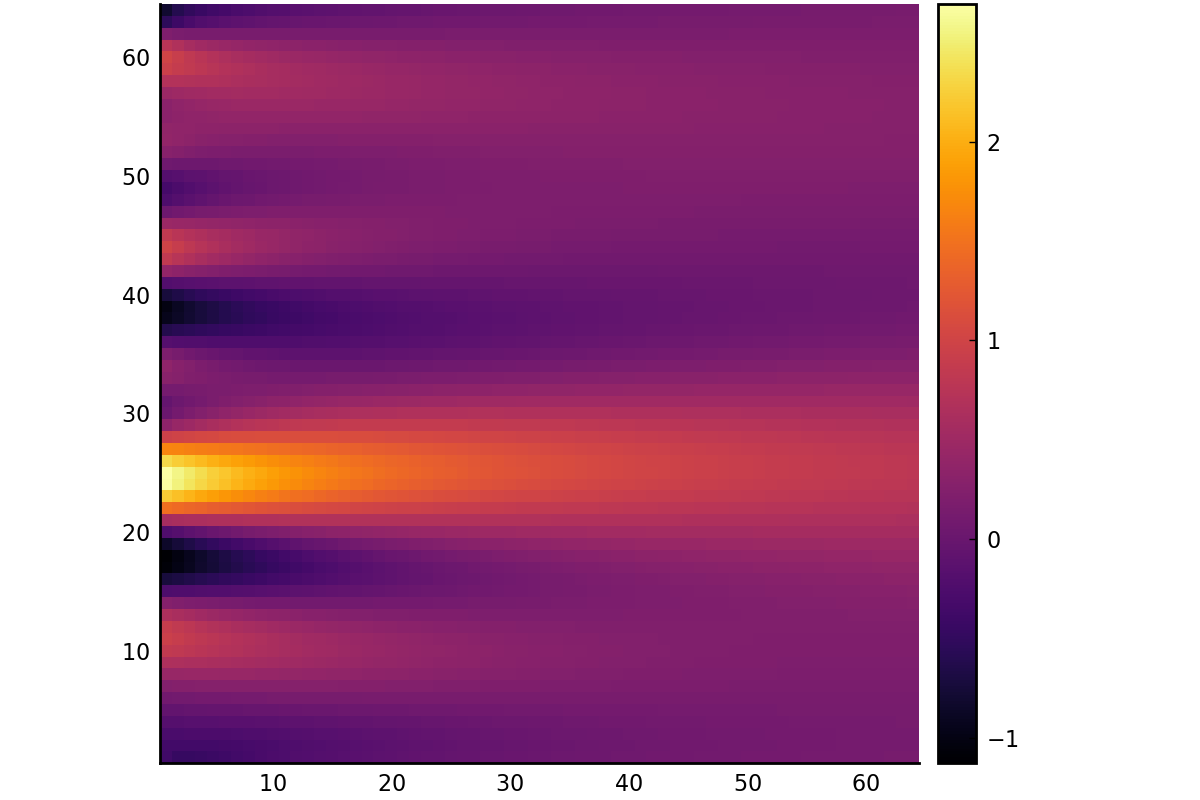

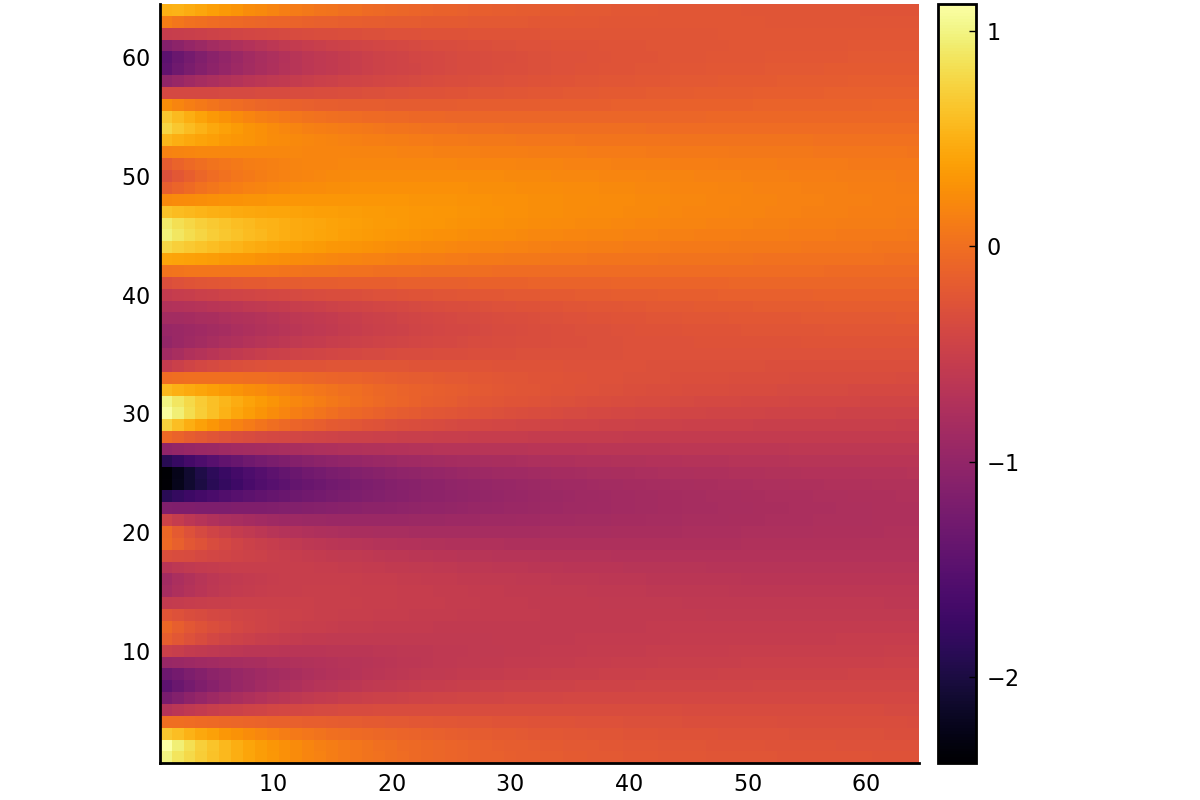

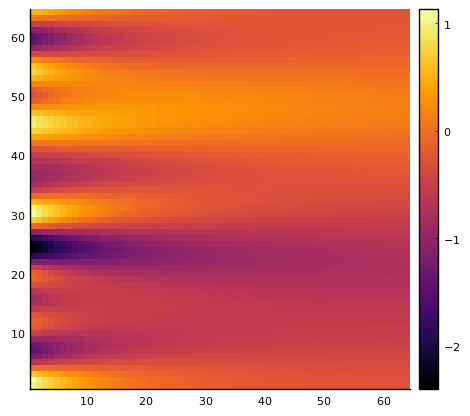

In [756]:
function check_training_dataset(dataset)
    for i in range(1, 10, step=1)
        a, b, c, d = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(dataset)

## Training with NeuralODE object

In [1027]:
callback(theta, loss) = (IJulia.clear_output(true); display(loss); false)

callback (generic function with 2 methods)

In [1051]:
function heat_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-8 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

heat_training (generic function with 2 methods)

In [1052]:
# t, u0, u_true = ProcessingTools.process_dataset(dataset);
net = Models.HeatModel(x_n);
result = heat_training(net, 100, init_set, u_true, t);

1.1017985495500087

1.00844933396055

0.9400054191300242

0.8873167511259757

0.8450004516101821

0.8097601038255653

0.77959474816344

0.753276627381305

0.7300096869849722

0.7092330601540848

0.6905173642994099

0.6735213122511015

0.6579777556798929

0.6436854627905162

0.6304962633386819

0.618298508127102

0.6070032775205166

0.5965363916744452

0.586834856480602

0.577844499965865

0.5695165684635061

0.5618035652280104

0.5546569335083913

0.5480281983064891

0.5418723339157008

0.536149244271473

0.5308205315261034

0.5258447217020226

0.5211784142257629

0.5167851380696729

0.5126431827517871

0.5087415624550718

0.5050657902007909

0.5015897023538772

0.4982845521257167

0.49513324950729004

0.4921297947334037

0.4892672497623839

0.48653445076047575

0.4839232326715657

0.4814287343879096

0.4790417772492106

0.47674975046147167

0.4745454965152951

0.47242767875266484

0.4703928953857668

0.4684342346170003

0.4665464817475259

0.4647270069908632

0.4629722864971696

0.4612769407067135

0.45963601267910437

0.4580472604596387

0.45650989904743305

0.4550205174837985

0.4535741134144908

0.4521689889743503

0.45080396903581105

0.44947484156037143

0.4481800054904792

0.4469203896532852

0.44569325769690726

0.44449591641429415

0.4433282749266984

0.44218890096673635

0.44107671146197835

0.43999122744057806

0.43893033757276545

0.43789280741502834

0.4368779232349694

0.43588514276143947

0.43491359327133083

0.4339612901000909

0.433028421082285

0.43211403555767763

0.43121670998067396

0.4303358593653475

0.42947112578074575

0.4286222120257781

0.4277881340448293

0.4269682957694641

0.4261621534952713

0.4253697720593853

0.42459018904641593

0.42382316359509886

0.4230684226255012

0.4223254216079479

0.4215936840163452

0.4208730442808449

0.42016298456464163

0.4194632307135853

0.41877332795559363

0.41809326838915695

0.4174224816618109

0.4167607114320813

0.4161078454959819

0.4154635318890158

0.41482766946141586

0.4141998636068788

0.41358007044497114

0.41358007044497114

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

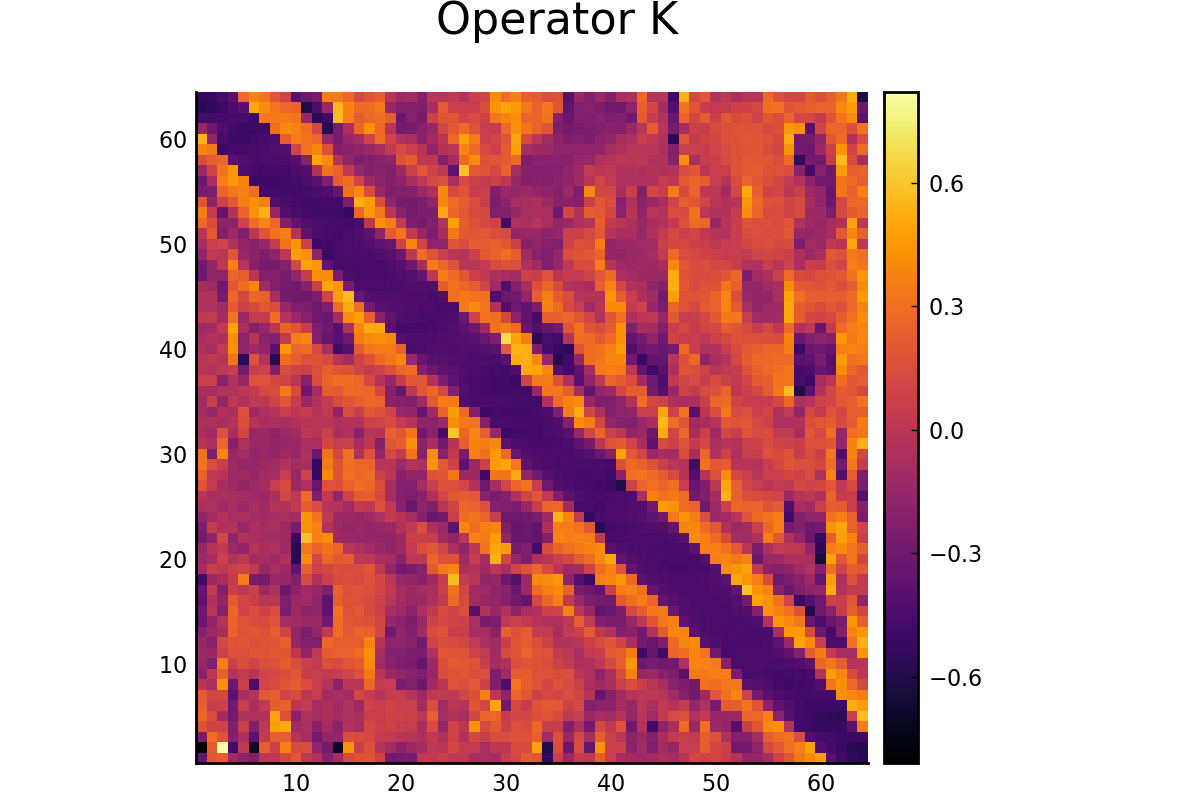

In [1053]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

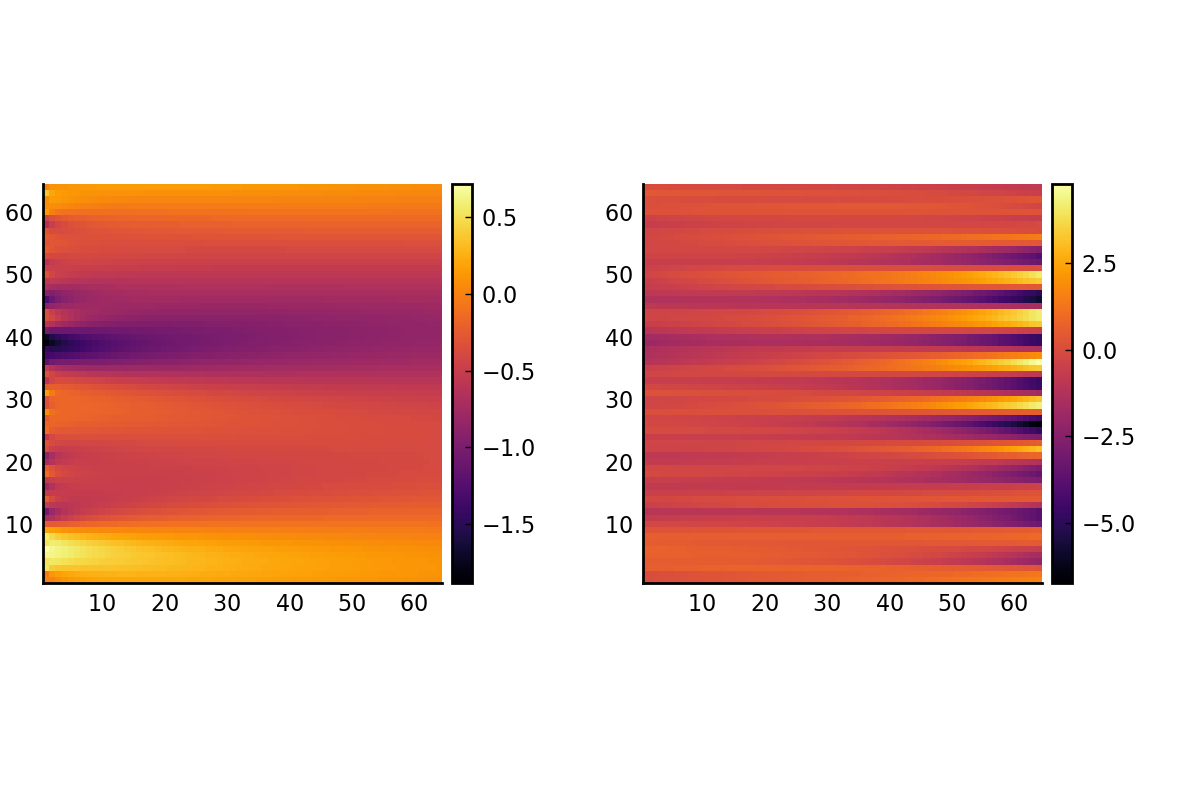

In [1059]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 3, d, k);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Training with solver

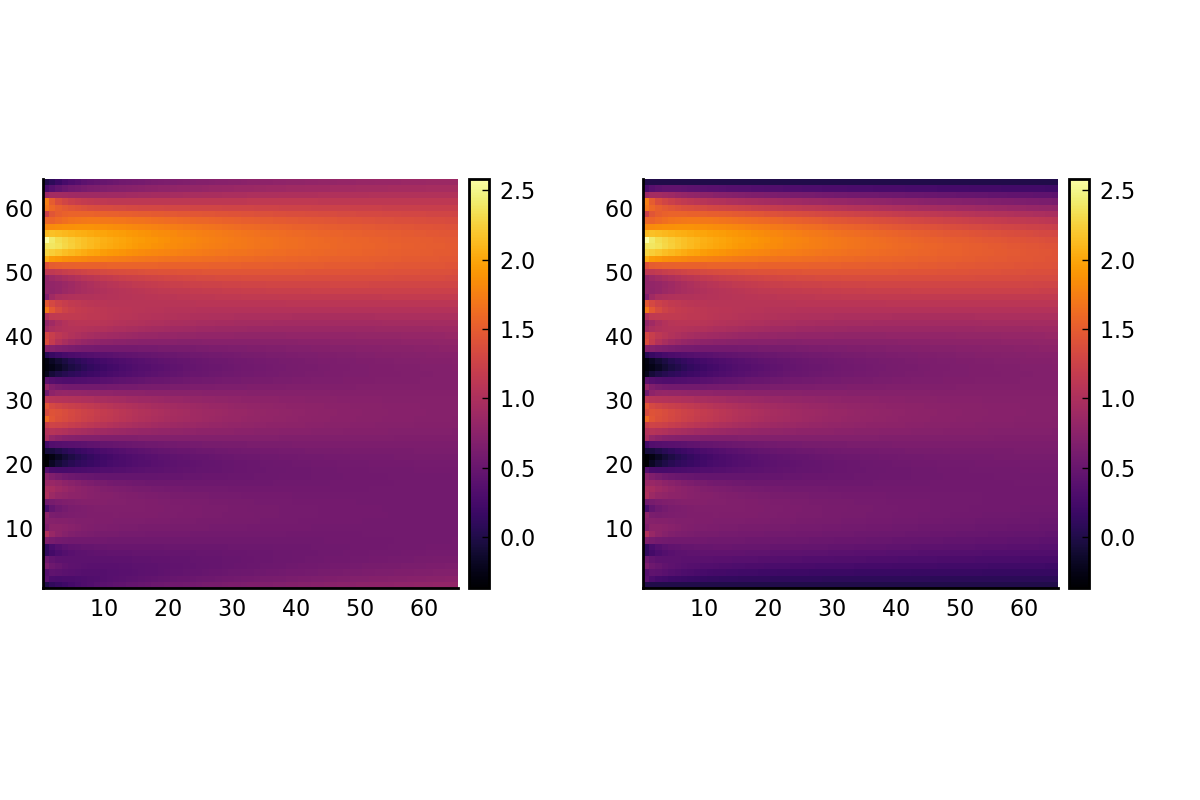

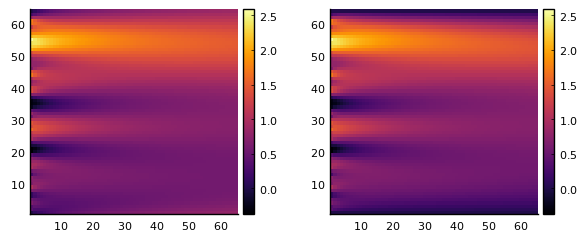

In [945]:
t, fft = Equations.get_heat_fft(tsnap, dx, x_n, κ, init[:, 2]);
display(
    plot(
    GraphicTools.show_state(fft, ""),
    GraphicTools.show_state(train[:,2,:], "");
    ),
)

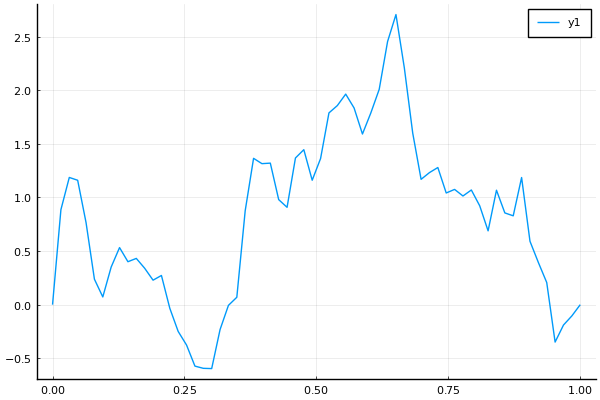

In [946]:
plot(x, init[:, 1];)

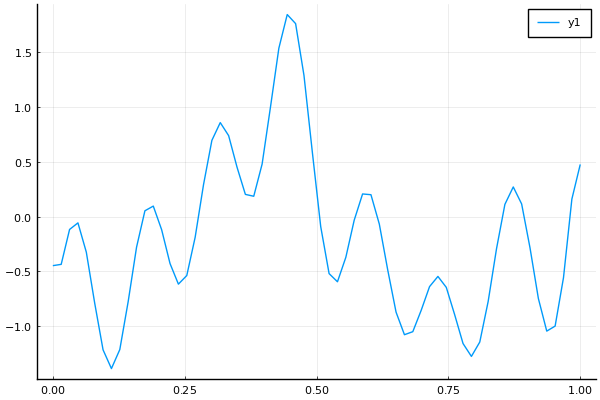

In [954]:
t, u0, u_true = process_dataset(dataset)
u0[:, 1]
plot(x, u0[:, 1];)

In [955]:
function f(u, K, t)
  return K * u
end

f (generic function with 1 method)

In [956]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 2 methods)

In [837]:
callback(A, loss) = (println(loss); flush(stdout); false)

function heat_training_2(A, epochs, u0, u_true, tsnap)
  
  function loss(A)
    u_pred = Array(S(A, u0, tsnap))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

heat_training_2 (generic function with 2 methods)

1.1017985495815394
1.0084493351747343
0.9400054277861623
0.8873167728093527
0.8450004682265104
0.8097601246338899
0.7795947892394468
0.7532766654712777
0.7300097185884271
0.7092330917829102
0.6905174031876213
0.6735213583908249
0.6579777867335064
0.6436854935591082
0.6304962896817647
0.6182985323291835
0.6070033073193688
0.596536427164448
0.586834891029094
0.5778445341785957
0.5695165964507589
0.561803589898336
0.5546569538313498
0.5480282210214112
0.5418723555858846
0.5361492640228496
0.5308205502198245
0.5258447414486009
0.5211784351634772
0.516785161046182
0.5126432067837489
0.5087415864140585
0.505065814594945
0.5015897246565721
0.4982845718337659
0.49513326608900304
0.49212980901650594
0.489267265204165
0.4865344673819744
0.4839232477977041
0.4814287474049366
0.47904178881915965
0.4767497630704844
0.4745455089641364
0.4724276905656129
0.4703929071577232
0.46843424599454475
0.4665464926273904
0.46472701731034793
0.4629722965472063
0.4612769503024156
0.4596360228017786
0.45804727130

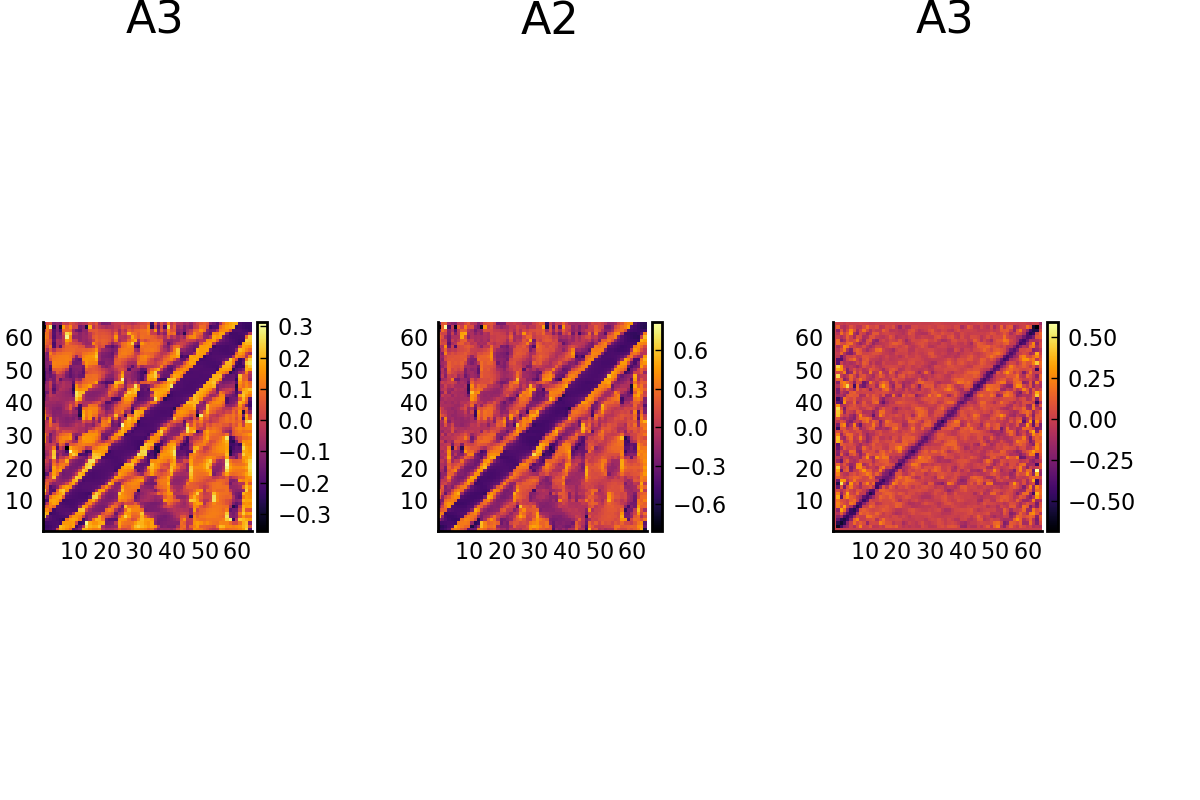

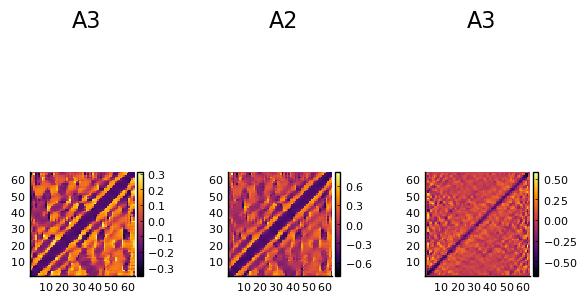

In [970]:
net = zeros(x_n, x_n)
t, u0, u_true = ProcessingTools.process_dataset(dataset);

result_2 = heat_training_2(copy(net), 100, u0, u_true, t);
result_3 = heat_training_2(copy(net), 100, init, train, tsnap);
Afit2 = result_2.u
Afit3 = result_3.u;

display(
    plot(
        GraphicTools.show_state(Afit, "A"),
        GraphicTools.show_state(Afit2, "A2"),
        GraphicTools.show_state(Afit3, "A3");
        layout = (1, 3),
    ),
);   

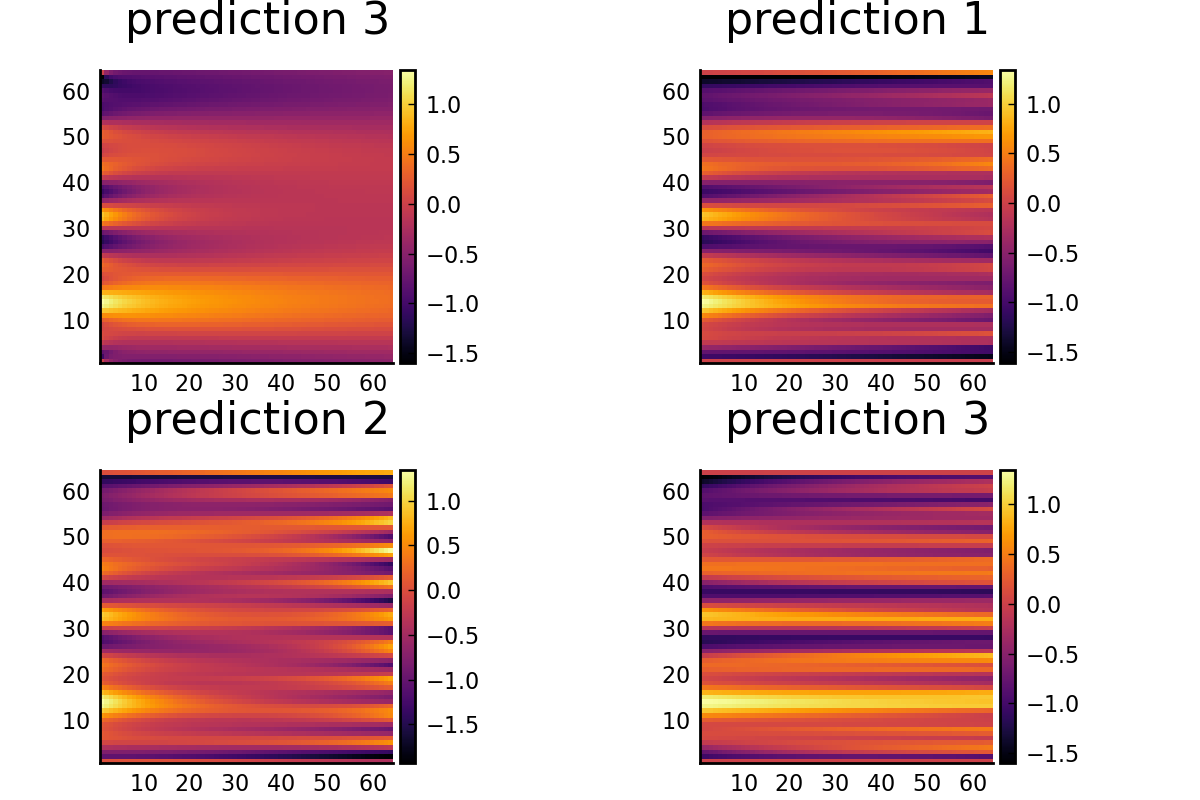

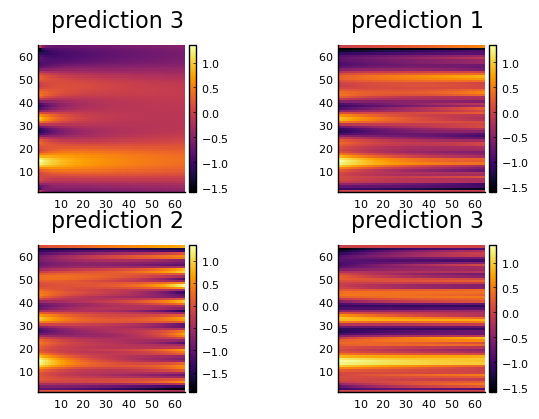

In [995]:
t, u0, u_true = ProcessingTools.process_dataset(dataset);

# t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, 64, 64, 2, d, k);
u_pred = Array(S(Afit, u0[, t));
u_pred_2 = Array(S(Afit2, u0, t));
u_pred_3 = Array(S(Afit3, u0, t));
# neural_ode = NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
# u_pred = Array(neural_ode(u0, result))

display(
    plot(
        GraphicTools.show_state(u, "data"),
        GraphicTools.show_state(u_pred, "prediction 1"),
        GraphicTools.show_state(u_pred_2, "prediction 2"),
        GraphicTools.show_state(u_pred_3, "prediction 3");
        layout = (2, 2),
    ),
);